In [1]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST datasets
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)
combined_dataset = ConcatDataset([train_dataset,test_dataset])

C:\Users\bratab1\AppData\Local\Temp\ipykernel_20472\1826676988.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


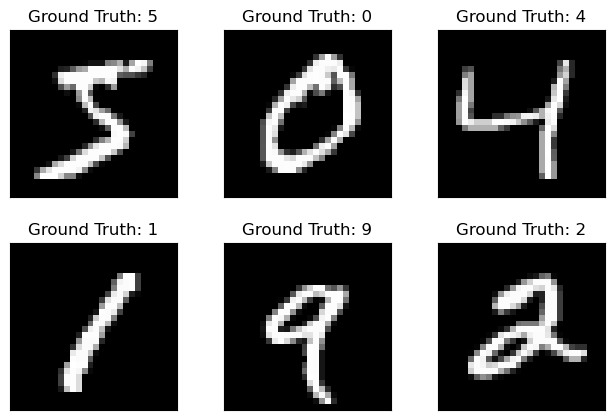

In [3]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(combined_dataset[i][0][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(combined_dataset[i][1]))
  plt.xticks([])
  plt.yticks([])


In [4]:
data_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [8]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [9]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data


In [10]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

Starting epoch 0...
g_loss: 1.0583062171936035, d_loss: 1.1708717346191406


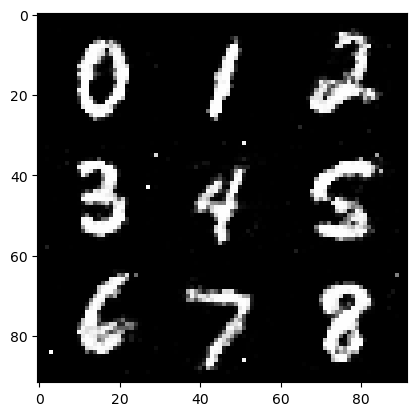

Starting epoch 1...
g_loss: 0.9370309710502625, d_loss: 1.3021330833435059


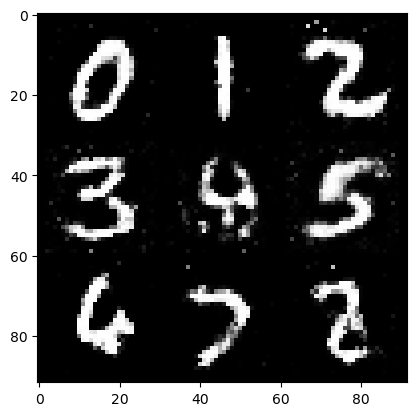

Starting epoch 2...
g_loss: 1.0952109098434448, d_loss: 1.1583513021469116


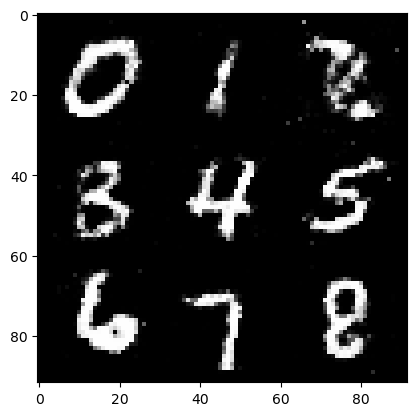

Starting epoch 3...
g_loss: 1.1021461486816406, d_loss: 1.2478681802749634


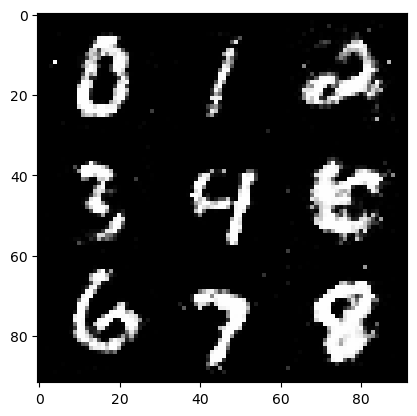

Starting epoch 4...
g_loss: 0.9195756316184998, d_loss: 0.9878886938095093


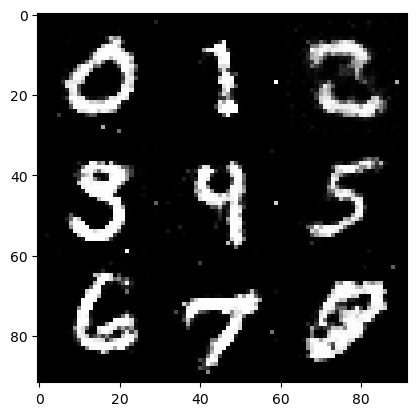

Starting epoch 5...
g_loss: 1.2054874897003174, d_loss: 1.2507903575897217


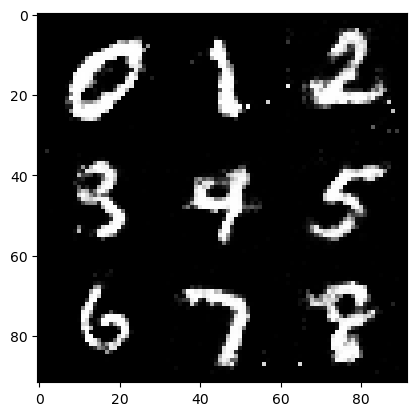

Starting epoch 6...
g_loss: 0.8895303606987, d_loss: 1.2587971687316895


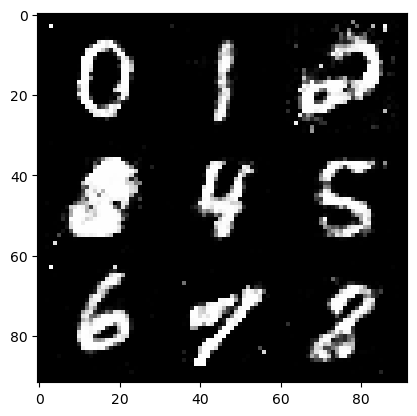

Starting epoch 7...
g_loss: 0.9707307815551758, d_loss: 1.1649079322814941


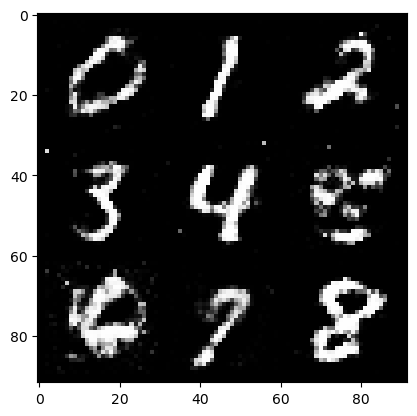

Starting epoch 8...
g_loss: 0.9635350108146667, d_loss: 1.1151809692382812


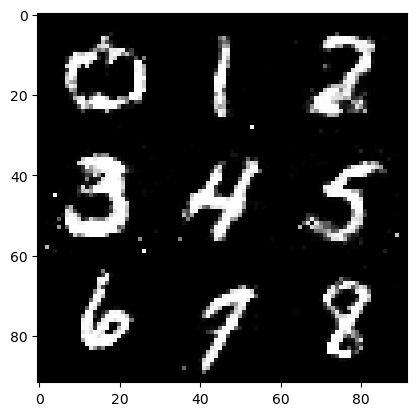

Starting epoch 9...
g_loss: 1.1654449701309204, d_loss: 0.9592097401618958


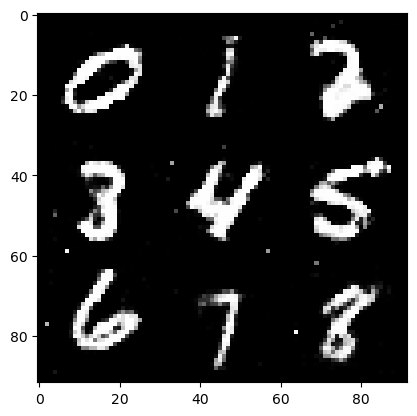

Starting epoch 10...
g_loss: 1.0156993865966797, d_loss: 1.147894024848938


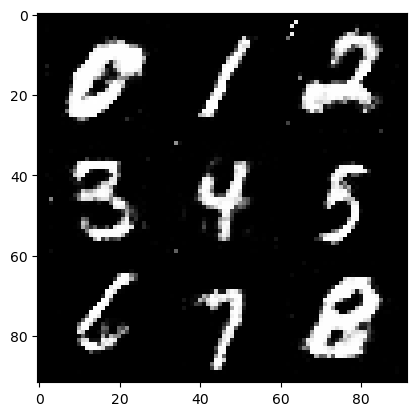

Starting epoch 11...
g_loss: 1.148909568786621, d_loss: 1.1646831035614014


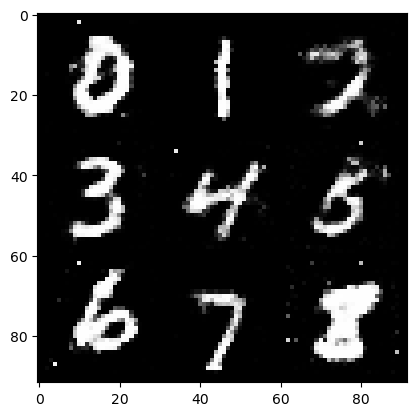

Starting epoch 12...
g_loss: 0.8416415452957153, d_loss: 1.361749291419983


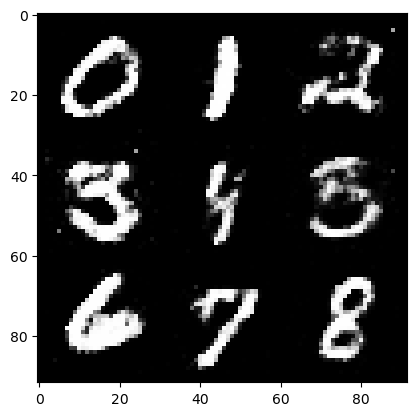

Starting epoch 13...
g_loss: 0.9889481067657471, d_loss: 1.1530606746673584


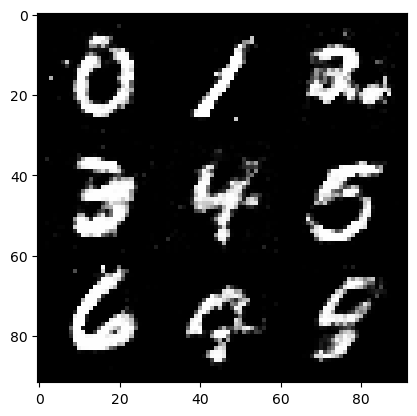

Starting epoch 14...
g_loss: 0.8117100596427917, d_loss: 1.2754631042480469


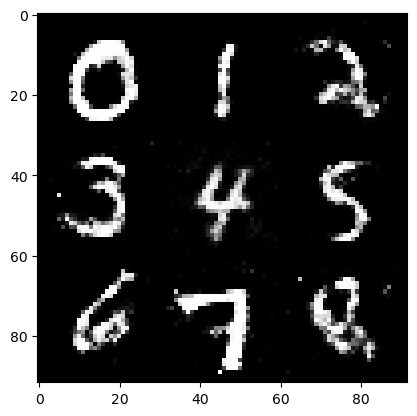

Starting epoch 15...
g_loss: 0.8928176760673523, d_loss: 1.3993408679962158


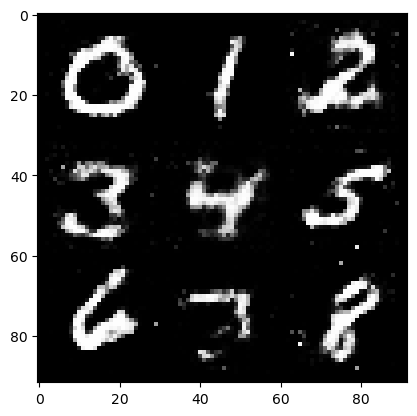

Starting epoch 16...
g_loss: 0.8313461542129517, d_loss: 1.1362338066101074


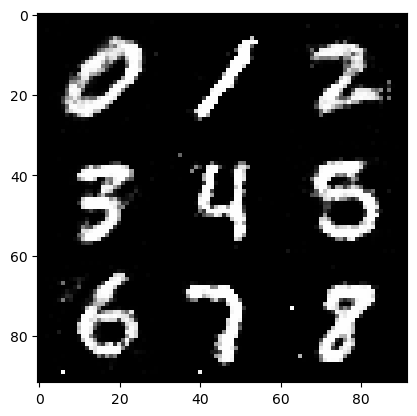

Starting epoch 17...
g_loss: 0.8085808157920837, d_loss: 1.3803021907806396


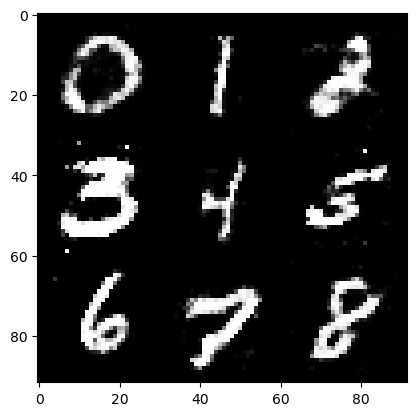

Starting epoch 18...
g_loss: 0.8735527396202087, d_loss: 1.2688560485839844


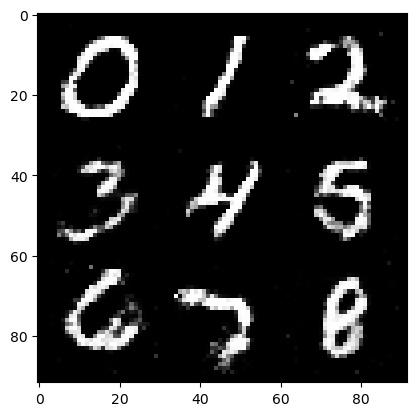

Starting epoch 19...
g_loss: 1.0847581624984741, d_loss: 1.126932144165039


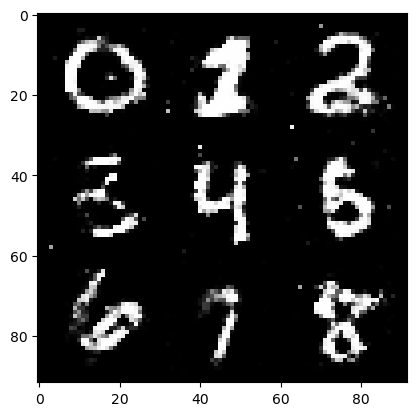

Starting epoch 20...
g_loss: 0.8981744647026062, d_loss: 1.1077663898468018


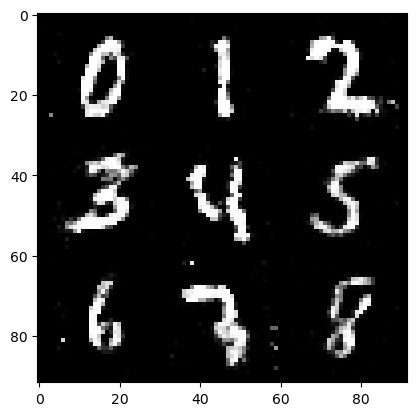

Starting epoch 21...
g_loss: 0.8044494390487671, d_loss: 1.3175694942474365


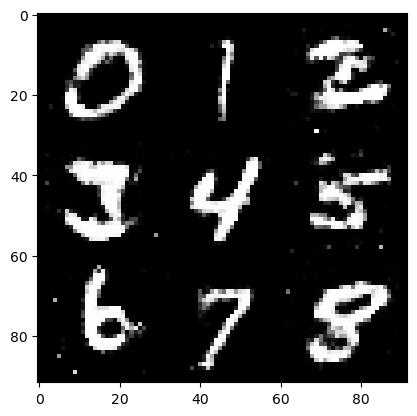

Starting epoch 22...
g_loss: 1.1178603172302246, d_loss: 1.1620755195617676


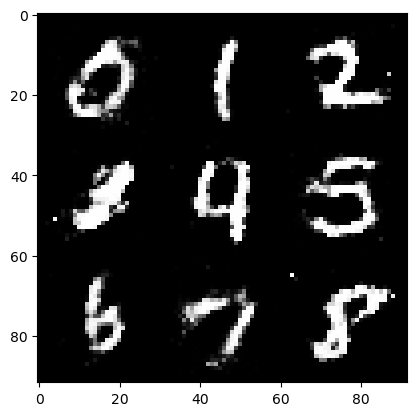

Starting epoch 23...
g_loss: 0.9174950122833252, d_loss: 1.2431960105895996


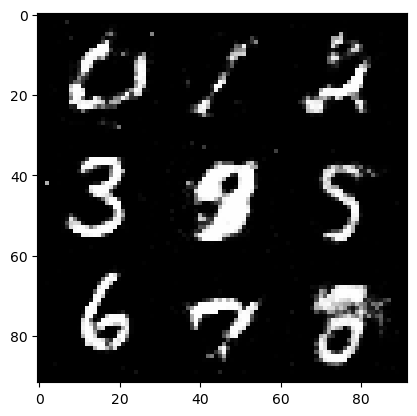

Starting epoch 24...
g_loss: 0.7272458076477051, d_loss: 1.4882807731628418


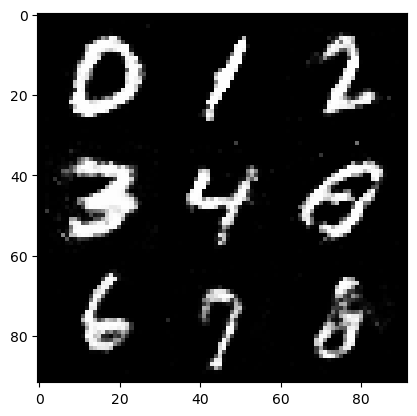

Starting epoch 25...
g_loss: 0.9778561592102051, d_loss: 1.2218496799468994


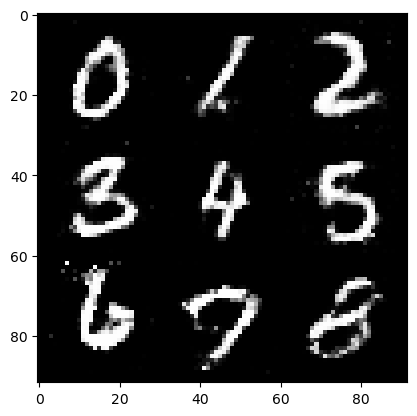

Starting epoch 26...
g_loss: 0.876137375831604, d_loss: 1.1378673315048218


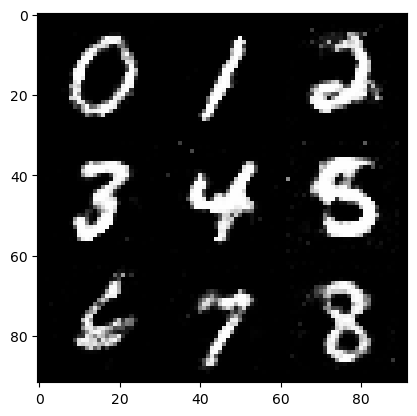

Starting epoch 27...
g_loss: 1.0249671936035156, d_loss: 1.1978720426559448


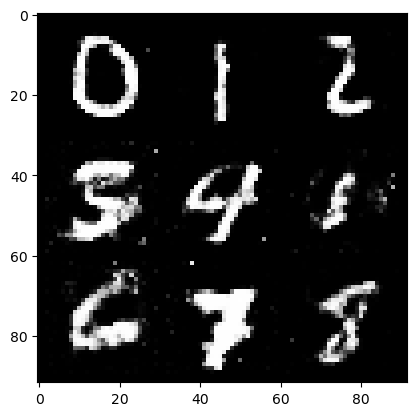

Starting epoch 28...
g_loss: 0.87543785572052, d_loss: 1.1726819276809692


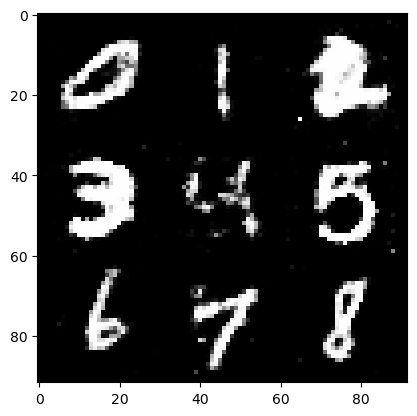

Starting epoch 29...
g_loss: 1.007226824760437, d_loss: 1.1681888103485107


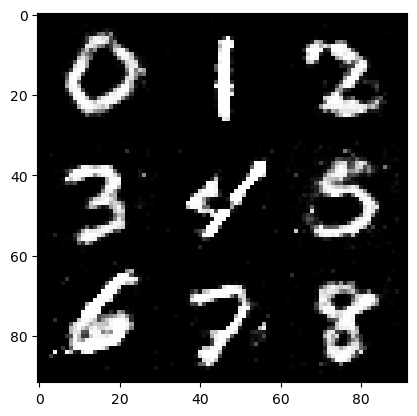

Starting epoch 30...
g_loss: 0.714154839515686, d_loss: 1.3266801834106445


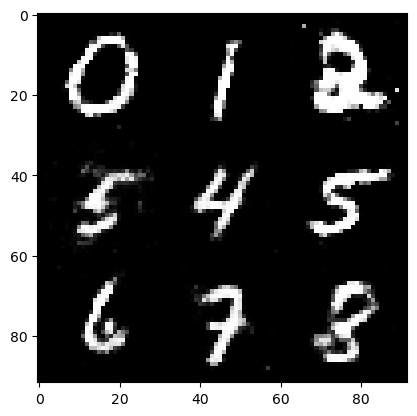

Starting epoch 31...
g_loss: 0.7876001596450806, d_loss: 1.2812578678131104


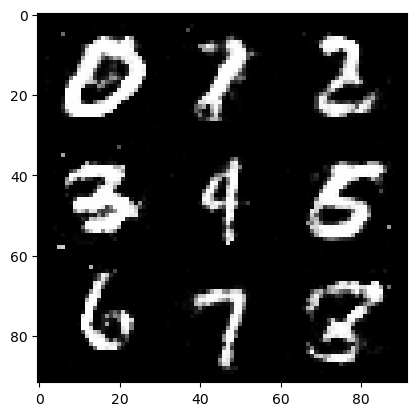

Starting epoch 32...
g_loss: 0.9274524450302124, d_loss: 1.4608714580535889


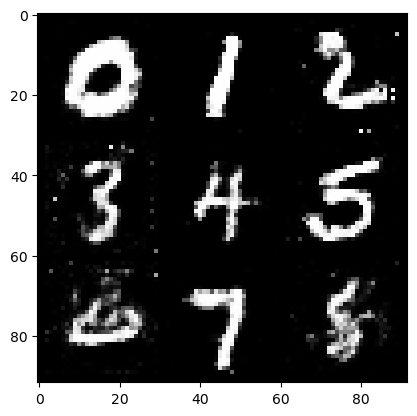

Starting epoch 33...
g_loss: 0.8385429382324219, d_loss: 1.3922619819641113


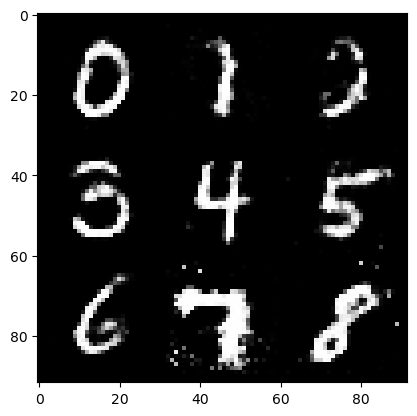

Starting epoch 34...
g_loss: 1.042624592781067, d_loss: 1.21969473361969


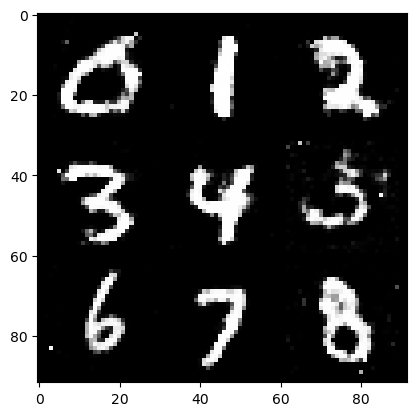

Starting epoch 35...
g_loss: 0.8404234647750854, d_loss: 1.229736089706421


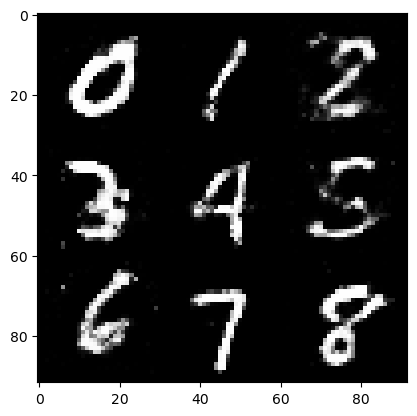

Starting epoch 36...
g_loss: 1.0599454641342163, d_loss: 1.2175730466842651


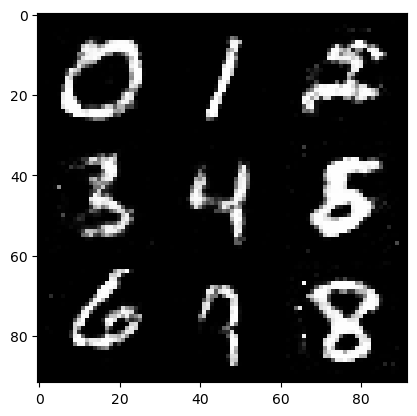

Starting epoch 37...
g_loss: 1.0306323766708374, d_loss: 1.339451789855957


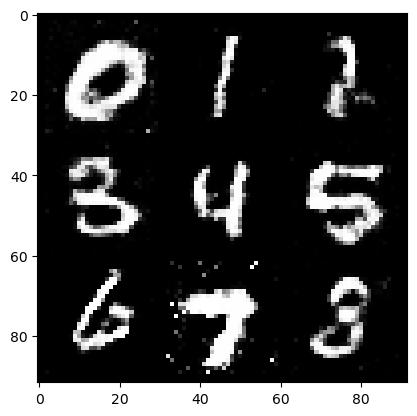

Starting epoch 38...
g_loss: 0.854204535484314, d_loss: 1.3787922859191895


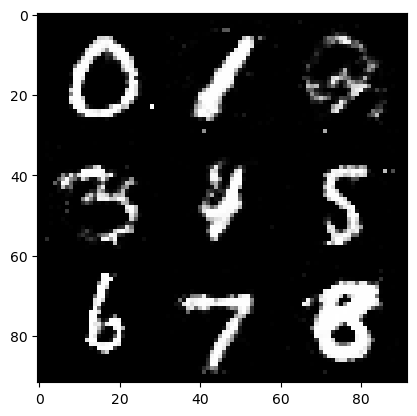

Starting epoch 39...
g_loss: 1.0357420444488525, d_loss: 1.421140432357788


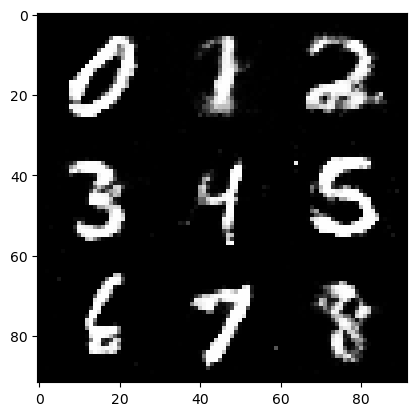

Starting epoch 40...
g_loss: 0.8511413335800171, d_loss: 1.2932658195495605


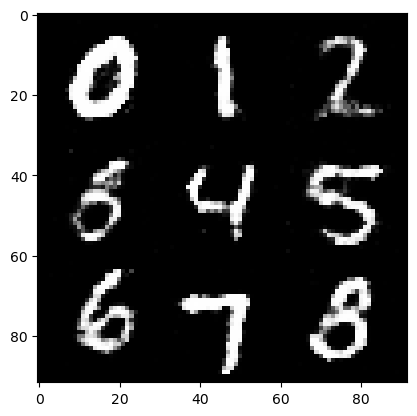

Starting epoch 41...
g_loss: 0.8633071780204773, d_loss: 1.3053244352340698


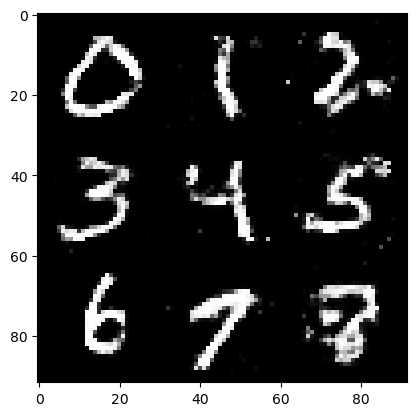

Starting epoch 42...
g_loss: 0.8734883069992065, d_loss: 1.1374911069869995


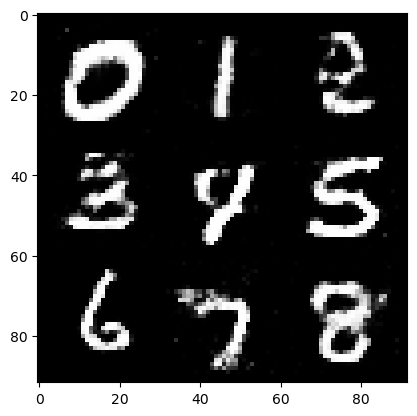

Starting epoch 43...
g_loss: 0.9138662219047546, d_loss: 1.242267370223999


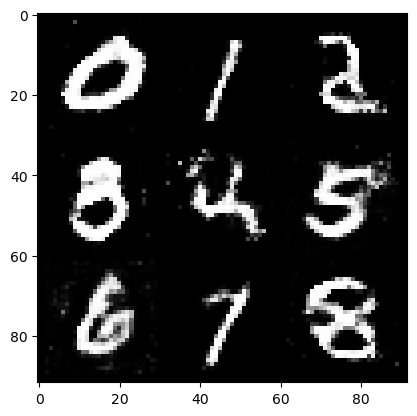

Starting epoch 44...
g_loss: 0.8539668917655945, d_loss: 1.3205643892288208


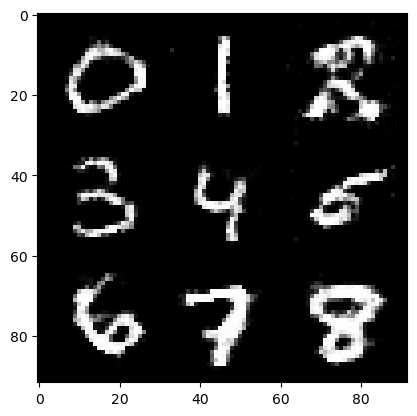

Starting epoch 45...
g_loss: 0.88958740234375, d_loss: 1.3624240159988403


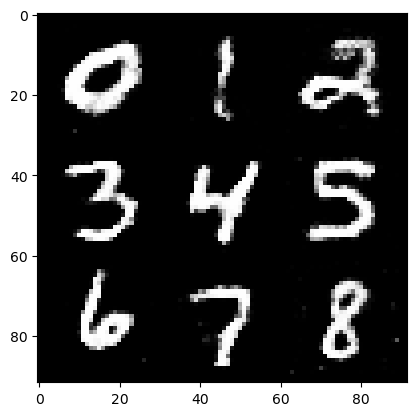

Starting epoch 46...
g_loss: 0.9096136093139648, d_loss: 1.2802363634109497


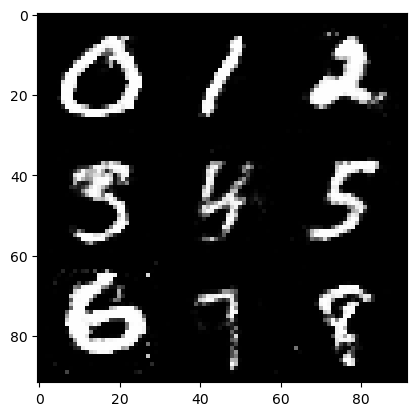

Starting epoch 47...
g_loss: 0.9442743062973022, d_loss: 1.195245385169983


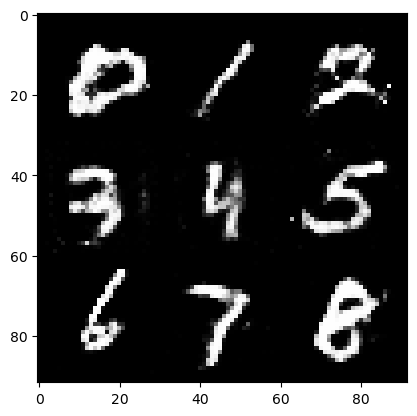

Starting epoch 48...
g_loss: 0.7056623697280884, d_loss: 1.4207713603973389


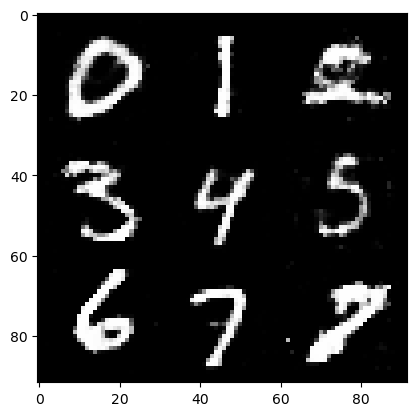

Starting epoch 49...
g_loss: 0.9682747721672058, d_loss: 1.2166335582733154


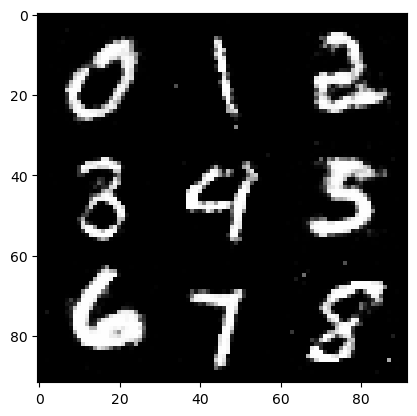

Starting epoch 50...
g_loss: 0.9202773571014404, d_loss: 1.3124191761016846


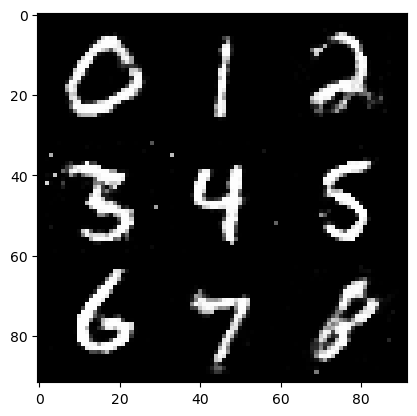

Starting epoch 51...
g_loss: 0.8745565414428711, d_loss: 1.256137728691101


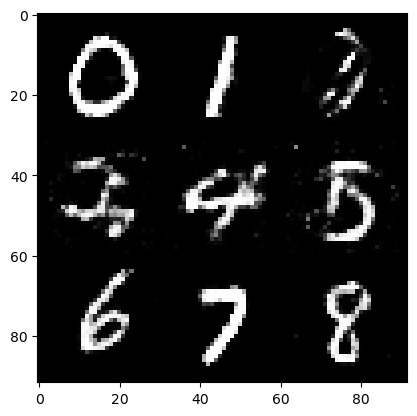

Starting epoch 52...
g_loss: 0.8826825022697449, d_loss: 1.352187156677246


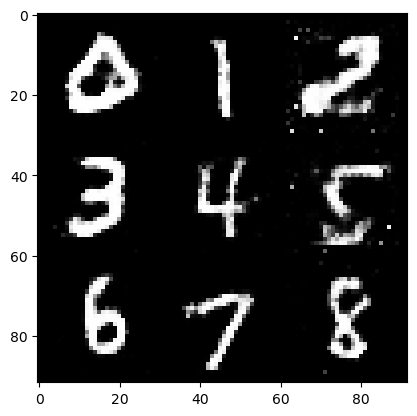

Starting epoch 53...
g_loss: 0.7683258056640625, d_loss: 1.2856714725494385


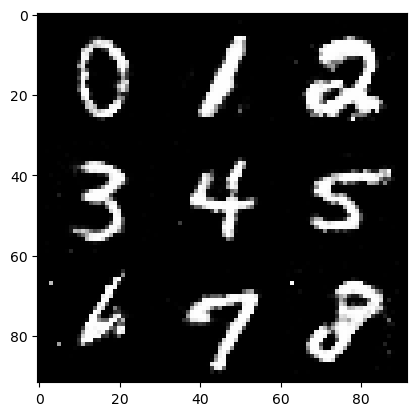

Starting epoch 54...
g_loss: 0.7844460010528564, d_loss: 1.3399658203125


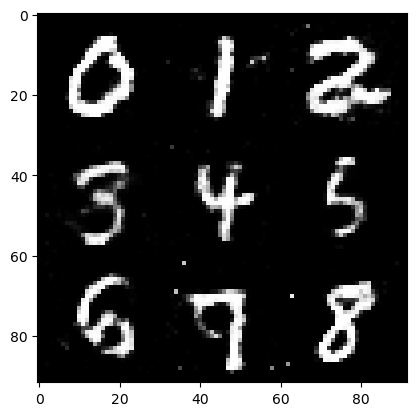

Starting epoch 55...
g_loss: 0.6683323383331299, d_loss: 1.4702668190002441


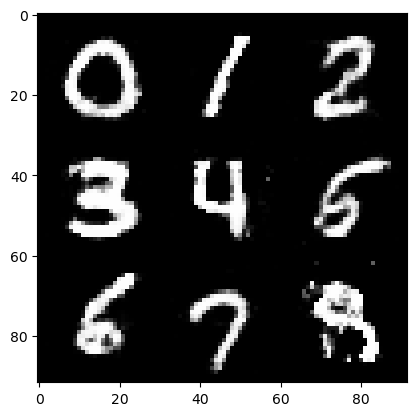

Starting epoch 56...
g_loss: 0.7832803130149841, d_loss: 1.2590422630310059


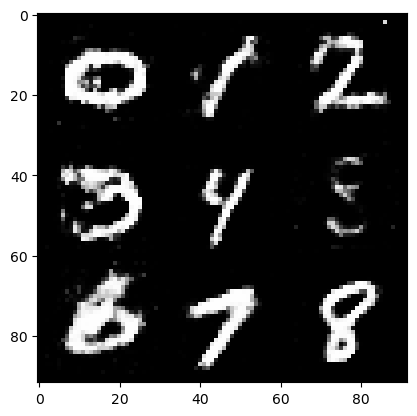

Starting epoch 57...
g_loss: 0.9452756643295288, d_loss: 1.4043797254562378


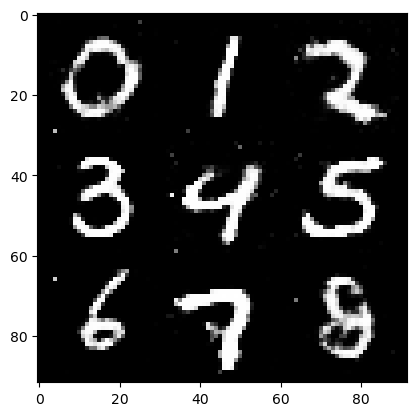

Starting epoch 58...
g_loss: 0.838199257850647, d_loss: 1.1687803268432617


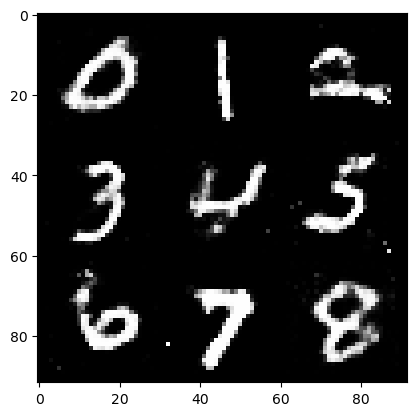

Starting epoch 59...
g_loss: 0.8930842280387878, d_loss: 1.2069135904312134


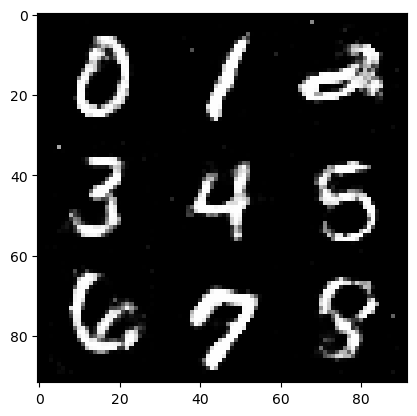

In [12]:
num_epochs = 60
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

In [13]:
dict = {'generator':generator.state_dict(),'discriminator':discriminator.state_dict()}

In [15]:
torch.save(dict,'./models/checkpoint.pth')